In [1]:
# Casi un millón de observaciones
# 1115 tiendas únicas 
# Notemos que las ventas es la variable objetivo (la que intentamos predecir)

# Id:  ID de transacción (combinación de la tienda y la fecha)
# Store: identificador único de la tienda
# Sales: ventas diarias, esta es la variable objetivo
# Customers: número de clientes de un día dado
# Open: Booleano para indicar si la tienda estaba abierta o cerrada (0 = cerrada, 1 = abierta)
# Promo: describe si la tienda tenía algún tipo de promoción ese día o no
# StateHoliday: indica si el día era festivo o no (a = vacaciones públicas, b = vacaciones de Pascua, c = Navidades, 0 = No era festivo)
# SchoolHoliday: indica si (Store, Date) se ve afectado por el cierre de las escuelas públicas
# Fuente original de los datos: https://www.kaggle.com/c/rossmann-store-sales/data


In [2]:
# StoreType: categoría que indica el tipo de tienda (a, b, c, d)
# Assortment:  a = básico, b = extra, c = extedido
# CompetitionDistance (en metros): distancia a la tienda de la competencia más cercana
# CompetitionOpenSince [Mes/Año]:  fecha en que abrió la competencia
# Promo2: Promo2 es una promoción continuada y consecutiva en algunas tiendas (0 = la tienda no participa, 1 = la tienda participa)
# Promo2Since [Año/Semana]: fecha en la que la tienda empieza a participar en la Promo2
# PromoInterval: describe los intervalos consecutivos donde la Promo2 empieza, indicando los meses en los que empieza la misma. P.e. "Feb,May,Aug,Nov" significa que cada nueva ronda de promoción empieza en Febrero, Mayo, Agosto, Noviembre de cualquier año de esa tienda


In [3]:
#!pip install prophet

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import datetime
import missingno as msno
from prophet import Prophet

In [5]:
# Importaremos el csv

df_sales = pd.read_csv('Data/train.csv')
df_info = pd.read_csv('Data/store.csv')

C:\Users\garfi\AppData\Local\Temp\ipykernel_45308\2268709427.py:3: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_sales = pd.read_csv('Data/train.csv')


In [6]:
df_sales.head()

Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      2          5  2015-07-31   6064        625     1      1            0   
2      3          5  2015-07-31   8314        821     1      1            0   
3      4          5  2015-07-31  13995       1498     1      1            0   
4      5          5  2015-07-31   4822        559     1      1            0   

   SchoolHoliday  
0              1  
1              1  
2              1  
3              1  
4              1

In [7]:
df_info.head()

Store StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
0      1         c          a               1270.0                        9.0   
1      2         a          a                570.0                       11.0   
2      3         a          a              14130.0                       12.0   
3      4         c          c                620.0                        9.0   
4      5         a          a              29910.0                        4.0   

   CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
0                    2008.0       0              NaN              NaN   
1                    2007.0       1             13.0           2010.0   
2                    2006.0       1             14.0           2011.0   
3                    2009.0       0              NaN              NaN   
4                    2015.0       0              NaN              NaN   

     PromoInterval  
0              NaN  
1  Jan,Apr,Jul,Oct  
2  Jan,Apr,Jul,Oct  
3              NaN  
4              NaN

In [8]:
df_sales.describe()

Store     DayOfWeek         Sales     Customers          Open  \
count  1.017209e+06  1.017209e+06  1.017209e+06  1.017209e+06  1.017209e+06   
mean   5.584297e+02  3.998341e+00  5.773819e+03  6.331459e+02  8.301067e-01   
std    3.219087e+02  1.997391e+00  3.849926e+03  4.644117e+02  3.755392e-01   
min    1.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    2.800000e+02  2.000000e+00  3.727000e+03  4.050000e+02  1.000000e+00   
50%    5.580000e+02  4.000000e+00  5.744000e+03  6.090000e+02  1.000000e+00   
75%    8.380000e+02  6.000000e+00  7.856000e+03  8.370000e+02  1.000000e+00   
max    1.115000e+03  7.000000e+00  4.155100e+04  7.388000e+03  1.000000e+00   

              Promo  SchoolHoliday  
count  1.017209e+06   1.017209e+06  
mean   3.815145e-01   1.786467e-01  
std    4.857586e-01   3.830564e-01  
min    0.000000e+00   0.000000e+00  
25%    0.000000e+00   0.000000e+00  
50%    0.000000e+00   0.000000e+00  
75%    1.000000e+00   0.000000e+00  
max    1.000000e+00   1.000000e+00

In [9]:
df_info.describe()

Store  CompetitionDistance  CompetitionOpenSinceMonth  \
count  1115.00000          1112.000000                 761.000000   
mean    558.00000          5404.901079                   7.224704   
std     322.01708          7663.174720                   3.212348   
min       1.00000            20.000000                   1.000000   
25%     279.50000           717.500000                   4.000000   
50%     558.00000          2325.000000                   8.000000   
75%     836.50000          6882.500000                  10.000000   
max    1115.00000         75860.000000                  12.000000   

       CompetitionOpenSinceYear       Promo2  Promo2SinceWeek  Promo2SinceYear  
count                761.000000  1115.000000       571.000000       571.000000  
mean                2008.668857     0.512108        23.595447      2011.763573  
std                    6.195983     0.500078        14.141984         1.674935  
min                 1900.000000     0.000000         1.000000      2009.000000  
25%                 2006.000000     0.000000        13.000000      2011.000000  
50%                 2010.000000     1.000000        22.000000      2012.000000  
75%                 2013.000000     1.000000        37.000000      2013.000000  
max                 2015.000000     1.000000        50.000000      2015.000000

In [10]:
# Visualizamos el tipo de datos
df_sales.dtypes

Store             int64
DayOfWeek         int64
Date             object
Sales             int64
Customers         int64
Open              int64
Promo             int64
StateHoliday     object
SchoolHoliday     int64
dtype: object

In [11]:
df_info.dtypes

Store                          int64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
dtype: object

In [12]:
# Analisis y tratamientos de los datos
#existe valores nulos

df_sales.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [13]:
def bar_grafic(x):
    fig = plt.Figure(figsize = (12,6))
    fig = px.bar(x = sales_df[x].value_counts().index, y = sales_df[x].value_counts(), color = sales_df[x].value_counts().index)
    fig.show()

In [14]:
df_sales.nunique()

Store             1115
DayOfWeek            7
Date               942
Sales            21734
Customers         4086
Open                 2
Promo                2
StateHoliday         5
SchoolHoliday        2
dtype: int64

In [15]:
def bar_grafic(x,color):
    fig = plt.Figure(figsize = (12,6))
    fig = px.bar(x = df_sales[x].value_counts().index, y = df_sales[x].value_counts(), color = color)
    fig.show()

In [16]:
color = ['abierto', 'Cerrado']

In [17]:
bar_grafic('Open', color)

In [18]:
df_sales = df_sales[df_sales['Open']==1]
print(len(df_sales[df_sales['Open']==0]))

0


In [19]:
df_sales.drop(['Open'], axis=1, inplace =True)
df_sales

Store  DayOfWeek        Date  Sales  Customers  Promo StateHoliday  \
0            1          5  2015-07-31   5263        555      1            0   
1            2          5  2015-07-31   6064        625      1            0   
2            3          5  2015-07-31   8314        821      1            0   
3            4          5  2015-07-31  13995       1498      1            0   
4            5          5  2015-07-31   4822        559      1            0   
...        ...        ...         ...    ...        ...    ...          ...   
1016776    682          2  2013-01-01   3375        566      0            a   
1016827    733          2  2013-01-01  10765       2377      0            a   
1016863    769          2  2013-01-01   5035       1248      0            a   
1017042    948          2  2013-01-01   4491       1039      0            a   
1017190   1097          2  2013-01-01   5961       1405      0            a   

         SchoolHoliday  
0                    1  
1                    1  
2                    1  
3                    1  
4                    1  
...                ...  
1016776              1  
1016827              1  
1016863              1  
1017042              1  
1017190              1  

[844392 rows x 8 columns]

In [20]:
#Faltan datos de la distacia entre las tiendas, incio de promocio y dia de apertura de la tienda
df_info.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

<AxesSubplot:>

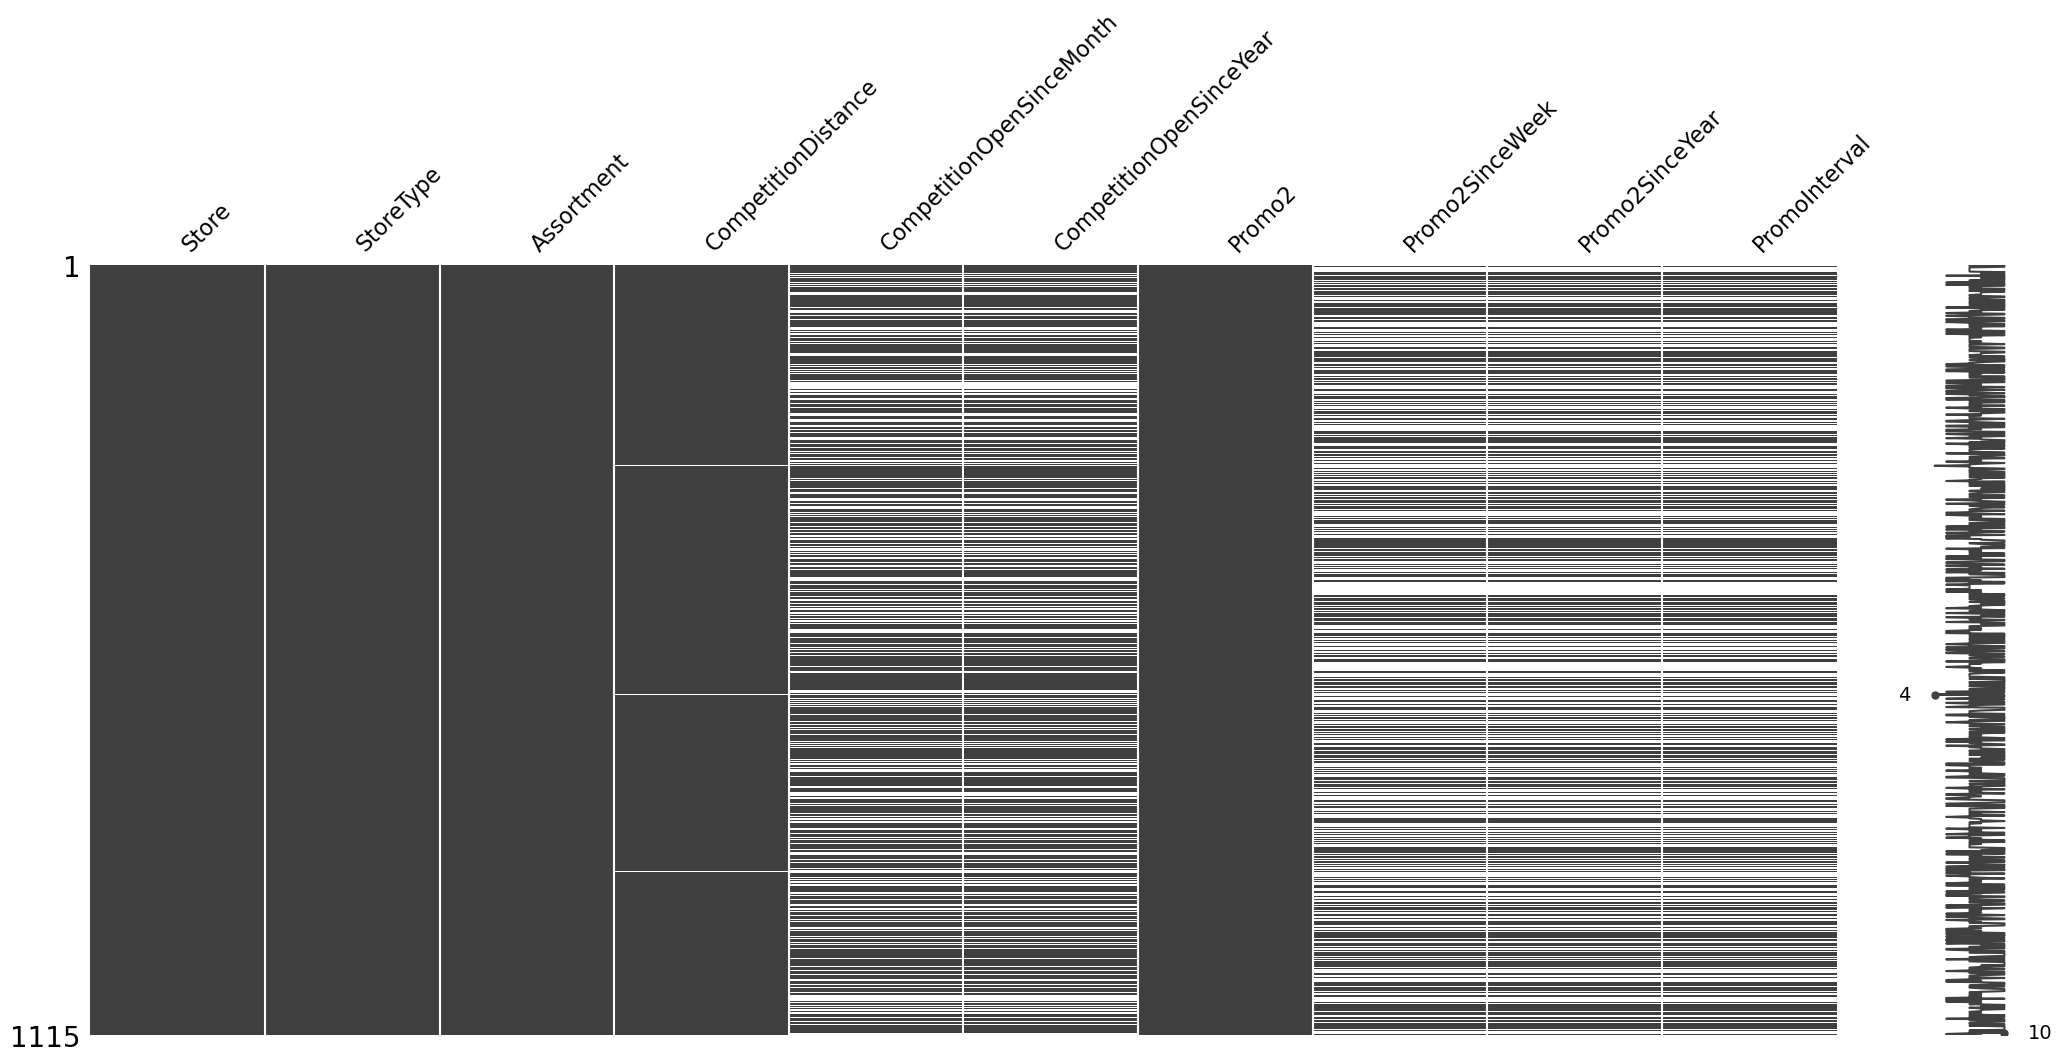

In [21]:
msno.matrix(df_info)

In [22]:
df_info[df_info['Promo2']==1]

Store StoreType Assortment  CompetitionDistance  \
1         2         a          a                570.0   
2         3         a          a              14130.0   
10       11         a          c                960.0   
11       12         a          c               1070.0   
12       13         d          a                310.0   
...     ...       ...        ...                  ...   
1105   1106         a          c               5330.0   
1106   1107         a          a               1400.0   
1108   1109         c          a               3490.0   
1110   1111         a          a               1900.0   
1114   1115         d          c               5350.0   

      CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
1                          11.0                    2007.0       1   
2                          12.0                    2006.0       1   
10                         11.0                    2011.0       1   
11                          NaN                       NaN       1   
12                          NaN                       NaN       1   
...                         ...                       ...     ...   
1105                        9.0                    2011.0       1   
1106                        6.0                    2012.0       1   
1108                        4.0                    2011.0       1   
1110                        6.0                    2014.0       1   
1114                        NaN                       NaN       1   

      Promo2SinceWeek  Promo2SinceYear     PromoInterval  
1                13.0           2010.0   Jan,Apr,Jul,Oct  
2                14.0           2011.0   Jan,Apr,Jul,Oct  
10                1.0           2012.0   Jan,Apr,Jul,Oct  
11               13.0           2010.0   Jan,Apr,Jul,Oct  
12               45.0           2009.0   Feb,May,Aug,Nov  
...               ...              ...               ...  
1105             31.0           2013.0   Jan,Apr,Jul,Oct  
1106             13.0           2010.0   Jan,Apr,Jul,Oct  
1108             22.0           2012.0   Jan,Apr,Jul,Oct  
1110             31.0           2013.0   Jan,Apr,Jul,Oct  
1114             22.0           2012.0  Mar,Jun,Sept,Dec  

[571 rows x 10 columns]

In [23]:
# Vemos que cuando 'Promo2' = 0, la tienda no participa y como no participa en la promocion entonces no hay una semana de promocion
df_info[df_info['Promo2']==0 & df_info['Promo2SinceWeek'].isnull()]

Store StoreType Assortment  CompetitionDistance  \
0         1         c          a               1270.0   
3         4         c          c                620.0   
4         5         a          a              29910.0   
5         6         a          a                310.0   
6         7         a          c              24000.0   
...     ...       ...        ...                  ...   
1107   1108         a          a                540.0   
1109   1110         c          c                900.0   
1111   1112         c          c               1880.0   
1112   1113         a          c               9260.0   
1113   1114         a          c                870.0   

      CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                           9.0                    2008.0       0   
3                           9.0                    2009.0       0   
4                           4.0                    2015.0       0   
5                          12.0                    2013.0       0   
6                           4.0                    2013.0       0   
...                         ...                       ...     ...   
1107                        4.0                    2004.0       0   
1109                        9.0                    2010.0       0   
1111                        4.0                    2006.0       0   
1112                        NaN                       NaN       0   
1113                        NaN                       NaN       0   

      Promo2SinceWeek  Promo2SinceYear PromoInterval  
0                 NaN              NaN           NaN  
3                 NaN              NaN           NaN  
4                 NaN              NaN           NaN  
5                 NaN              NaN           NaN  
6                 NaN              NaN           NaN  
...               ...              ...           ...  
1107              NaN              NaN           NaN  
1109              NaN              NaN           NaN  
1111              NaN              NaN           NaN  
1112              NaN              NaN           NaN  
1113              NaN              NaN           NaN  

[544 rows x 10 columns]

In [24]:
df_info[df_info['CompetitionOpenSinceMonth'].isnull()]

Store StoreType Assortment  CompetitionDistance  \
11       12         a          c               1070.0   
12       13         d          a                310.0   
15       16         a          c               3270.0   
18       19         a          c               3240.0   
21       22         a          a               1040.0   
...     ...       ...        ...                  ...   
1095   1096         a          c               1130.0   
1099   1100         a          a                540.0   
1112   1113         a          c               9260.0   
1113   1114         a          c                870.0   
1114   1115         d          c               5350.0   

      CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
11                          NaN                       NaN       1   
12                          NaN                       NaN       1   
15                          NaN                       NaN       0   
18                          NaN                       NaN       1   
21                          NaN                       NaN       1   
...                         ...                       ...     ...   
1095                        NaN                       NaN       1   
1099                        NaN                       NaN       1   
1112                        NaN                       NaN       0   
1113                        NaN                       NaN       0   
1114                        NaN                       NaN       1   

      Promo2SinceWeek  Promo2SinceYear     PromoInterval  
11               13.0           2010.0   Jan,Apr,Jul,Oct  
12               45.0           2009.0   Feb,May,Aug,Nov  
15                NaN              NaN               NaN  
18               22.0           2011.0  Mar,Jun,Sept,Dec  
21               22.0           2012.0   Jan,Apr,Jul,Oct  
...               ...              ...               ...  
1095             10.0           2014.0  Mar,Jun,Sept,Dec  
1099             14.0           2011.0   Jan,Apr,Jul,Oct  
1112              NaN              NaN               NaN  
1113              NaN              NaN               NaN  
1114             22.0           2012.0  Mar,Jun,Sept,Dec  

[354 rows x 10 columns]

In [25]:
# Vamos a ver que tiendas informacion tienen

df_info[df_info['CompetitionDistance'].isnull()]

Store StoreType Assortment  CompetitionDistance  \
290    291         d          a                  NaN   
621    622         a          c                  NaN   
878    879         d          a                  NaN   

     CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
290                        NaN                       NaN       0   
621                        NaN                       NaN       0   
878                        NaN                       NaN       1   

     Promo2SinceWeek  Promo2SinceYear    PromoInterval  
290              NaN              NaN              NaN  
621              NaN              NaN              NaN  
878              5.0           2013.0  Feb,May,Aug,Nov

In [26]:
# LLenaremos los valores faltantes con valores nulos y los valores faltantes del dato de la distancia media con el promedio

str_cols = ['Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth']

for str in str_cols:
    df_info[str].fillna(0, inplace = True)

df_info['CompetitionDistance'].fillna(df_info['CompetitionDistance'].mean(), inplace =True)

In [27]:
# Verificamos si siguen existiendo valores nulos
df_info.isnull().sum()

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

In [28]:
def bar_grafic2(x):
    fig = plt.Figure(figsize = (12,6))
    fig = px.bar(x = df_info[x].value_counts().index, y = df_info[x].value_counts(), color = list(df_info[x].unique()))
    fig.show()

In [29]:
df_info.nunique()

Store                        1115
StoreType                       4
Assortment                      3
CompetitionDistance           655
CompetitionOpenSinceMonth      13
CompetitionOpenSinceYear       24
Promo2                          2
Promo2SinceWeek                25
Promo2SinceYear                 8
PromoInterval                   4
dtype: int64

In [30]:
bar_grafic2('StoreType')

In [31]:
bar_grafic2("Promo2")

In [32]:

bar_grafic2('Assortment')

In [33]:

fig = px.histogram(x=df_info['CompetitionDistance'], nbins=20)
fig.update_traces(xbins_start=0, selector=dict(type='histogram'))
fig.show()

In [34]:
# Vamos a combinar los datos

df_all  = pd.merge(df_sales, df_info, how = 'inner', on = 'Store')

In [35]:
df_all

Store  DayOfWeek        Date  Sales  Customers  Promo StateHoliday  \
0           1          5  2015-07-31   5263        555      1            0   
1           1          4  2015-07-30   5020        546      1            0   
2           1          3  2015-07-29   4782        523      1            0   
3           1          2  2015-07-28   5011        560      1            0   
4           1          1  2015-07-27   6102        612      1            0   
...       ...        ...         ...    ...        ...    ...          ...   
844387    292          1  2013-01-07   9291       1002      1            0   
844388    292          6  2013-01-05   2748        340      0            0   
844389    292          5  2013-01-04   4202        560      0            0   
844390    292          4  2013-01-03   4580        662      0            0   
844391    292          3  2013-01-02   5076        672      0            0   

        SchoolHoliday StoreType Assortment  CompetitionDistance  \
0                   1         c          a               1270.0   
1                   1         c          a               1270.0   
2                   1         c          a               1270.0   
3                   1         c          a               1270.0   
4                   1         c          a               1270.0   
...               ...       ...        ...                  ...   
844387              0         a          a               1100.0   
844388              0         a          a               1100.0   
844389              1         a          a               1100.0   
844390              1         a          a               1100.0   
844391              1         a          a               1100.0   

        CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                             9.0                    2008.0       0   
1                             9.0                    2008.0       0   
2                             9.0                    2008.0       0   
3                             9.0                    2008.0       0   
4                             9.0                    2008.0       0   
...                           ...                       ...     ...   
844387                        6.0                    2009.0       0   
844388                        6.0                    2009.0       0   
844389                        6.0                    2009.0       0   
844390                        6.0                    2009.0       0   
844391                        6.0                    2009.0       0   

        Promo2SinceWeek  Promo2SinceYear PromoInterval  
0                   0.0              0.0             0  
1                   0.0              0.0             0  
2                   0.0              0.0             0  
3                   0.0              0.0             0  
4                   0.0              0.0             0  
...                 ...              ...           ...  
844387              0.0              0.0             0  
844388              0.0              0.0             0  
844389              0.0              0.0             0  
844390              0.0              0.0             0  
844391              0.0              0.0             0  

[844392 rows x 17 columns]

In [36]:
df_all.to_csv('Data/test.csv', index = False)

In [37]:
correlation_matrix = df_all.corr()['Sales'].sort_values()
correlation_matrix

DayOfWeek                   -0.178736
Promo2SinceYear             -0.127621
Promo2                      -0.127596
Promo2SinceWeek             -0.058476
CompetitionDistance         -0.036343
CompetitionOpenSinceMonth   -0.018370
CompetitionOpenSinceYear     0.005266
Store                        0.007710
SchoolHoliday                0.038617
Promo                        0.368145
Customers                    0.823597
Sales                        1.000000
Name: Sales, dtype: float64

In [38]:
!pip install searborn

ERROR: Could not find a version that satisfies the requirement searborn (from versions: none)
ERROR: No matching distribution found for searborn


<AxesSubplot:>

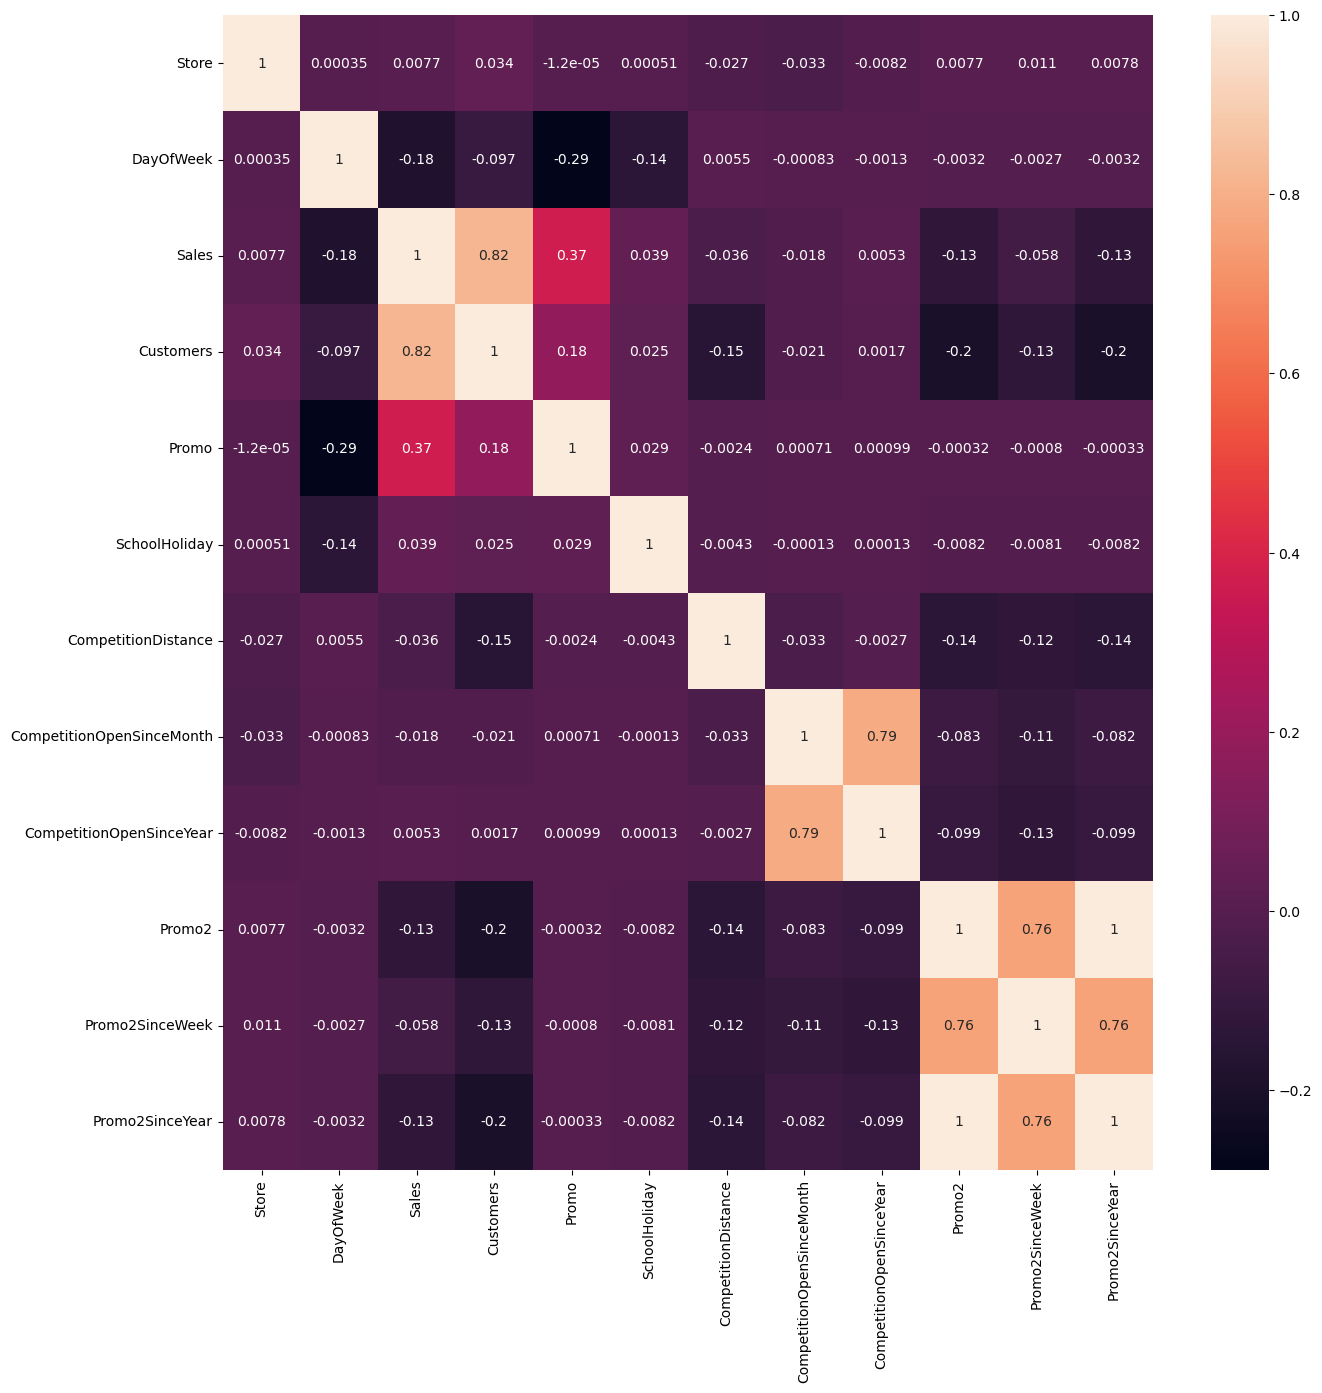

In [39]:
correlations = df_all.corr()
f, ax = plt.subplots(figsize = (15,15))
sns.heatmap(correlations, annot=True)

In [40]:
df_all['Year'] = pd.DatetimeIndex(df_all['Date']).year
df_all['day'] =pd.DatetimeIndex(df_all['Date']).day
df_all['Month'] =pd.DatetimeIndex(df_all['Date']).month

In [41]:
df_all

Store  DayOfWeek        Date  Sales  Customers  Promo StateHoliday  \
0           1          5  2015-07-31   5263        555      1            0   
1           1          4  2015-07-30   5020        546      1            0   
2           1          3  2015-07-29   4782        523      1            0   
3           1          2  2015-07-28   5011        560      1            0   
4           1          1  2015-07-27   6102        612      1            0   
...       ...        ...         ...    ...        ...    ...          ...   
844387    292          1  2013-01-07   9291       1002      1            0   
844388    292          6  2013-01-05   2748        340      0            0   
844389    292          5  2013-01-04   4202        560      0            0   
844390    292          4  2013-01-03   4580        662      0            0   
844391    292          3  2013-01-02   5076        672      0            0   

        SchoolHoliday StoreType Assortment  CompetitionDistance  \
0                   1         c          a               1270.0   
1                   1         c          a               1270.0   
2                   1         c          a               1270.0   
3                   1         c          a               1270.0   
4                   1         c          a               1270.0   
...               ...       ...        ...                  ...   
844387              0         a          a               1100.0   
844388              0         a          a               1100.0   
844389              1         a          a               1100.0   
844390              1         a          a               1100.0   
844391              1         a          a               1100.0   

        CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                             9.0                    2008.0       0   
1                             9.0                    2008.0       0   
2                             9.0                    2008.0       0   
3                             9.0                    2008.0       0   
4                             9.0                    2008.0       0   
...                           ...                       ...     ...   
844387                        6.0                    2009.0       0   
844388                        6.0                    2009.0       0   
844389                        6.0                    2009.0       0   
844390                        6.0                    2009.0       0   
844391                        6.0                    2009.0       0   

        Promo2SinceWeek  Promo2SinceYear PromoInterval  Year  day  Month  
0                   0.0              0.0             0  2015   31      7  
1                   0.0              0.0             0  2015   30      7  
2                   0.0              0.0             0  2015   29      7  
3                   0.0              0.0             0  2015   28      7  
4                   0.0              0.0             0  2015   27      7  
...                 ...              ...           ...   ...  ...    ...  
844387              0.0              0.0             0  2013    7      1  
844388              0.0              0.0             0  2013    5      1  
844389              0.0              0.0             0  2013    4      1  
844390              0.0              0.0             0  2013    3      1  
844391              0.0              0.0             0  2013    2      1  

[844392 rows x 20 columns]

In [42]:
df_all.groupby('Year').mean()

Store  DayOfWeek        Sales   Customers     Promo  SchoolHoliday  \
Year                                                                            
2013  558.014556   3.520301  6814.392025  757.537292  0.434967       0.204425   
2014  559.107346   3.512833  7025.404201  774.728739  0.445923       0.202276   
2015  558.043115   3.532388  7088.126648  752.674864  0.466659       0.161111   

      CompetitionDistance  CompetitionOpenSinceMonth  \
Year                                                   
2013          5434.052800                   4.932397   
2014          5499.333382                   4.918452   
2015          5433.151873                   4.929042   

      CompetitionOpenSinceYear    Promo2  Promo2SinceWeek  Promo2SinceYear  \
Year                                                                         
2013               1370.480264  0.510725        12.047307      1027.458684   
2014               1368.271883  0.478495        10.837184       962.604854   
2015               1370.566351  0.509896        12.020078      1025.792014   

            day     Month  
Year                       
2013  15.806458  6.523372  
2014  15.745426  6.259486  
2015  16.028985  4.022379

In [43]:
df_all['ORDERDATE'] = pd.to_datetime(df_all['Date'])

In [44]:
df_all.groupby('Date').mean()

Store  DayOfWeek        Sales    Customers  Promo  \
Date                                                                 
2013-01-01  529.058824        2.0  5719.705882  1146.529412    0.0   
2013-01-02  557.943294        3.0  6255.471647   750.742574    0.0   
2013-01-03  558.138864        4.0  5723.913436   686.239856    0.0   
2013-01-04  558.180505        5.0  5991.835740   705.899819    0.0   
2013-01-05  558.217706        6.0  5376.326107   621.022584    0.0   
...                ...        ...          ...          ...    ...   
2015-07-27  557.953279        1.0  9620.208446   871.933513    1.0   
2015-07-28  557.953279        2.0  8189.643306   787.144654    1.0   
2015-07-29  557.953279        3.0  7636.982929   744.406110    1.0   
2015-07-30  557.953279        4.0  7905.529200   771.380952    1.0   
2015-07-31  557.953279        5.0  9083.326146   870.278527    1.0   

            SchoolHoliday  CompetitionDistance  CompetitionOpenSinceMonth  \
Date                                                                        
2013-01-01       1.000000          2105.294118                   3.352941   
2013-01-02       1.000000          5416.817915                   4.937894   
2013-01-03       0.932372          5422.808569                   4.940487   
2013-01-04       0.932310          5427.170310                   4.944946   
2013-01-05       0.100271          5411.756733                   4.949413   
...                   ...                  ...                        ...   
2015-07-27       0.772686          5394.047352                   4.930818   
2015-07-28       0.772686          5394.047352                   4.930818   
2015-07-29       0.772686          5394.047352                   4.930818   
2015-07-30       0.838275          5394.047352                   4.930818   
2015-07-31       0.838275          5394.047352                   4.930818   

            CompetitionOpenSinceYear    Promo2  Promo2SinceWeek  \
Date                                                              
2013-01-01                944.941176  0.294118         6.352941   
2013-01-02               1370.447345  0.513051        12.117912   
2013-01-03               1371.103697  0.513075        12.130748   
2013-01-04               1372.341155  0.512635        12.137184   
2013-01-05               1373.580849  0.513098        12.148148   
...                              ...       ...              ...   
2015-07-27               1369.796047  0.512129        12.088949   
2015-07-28               1369.796047  0.512129        12.088949   
2015-07-29               1369.796047  0.512129        12.088949   
2015-07-30               1369.796047  0.512129        12.088949   
2015-07-31               1369.796047  0.512129        12.088949   

            Promo2SinceYear    Year   day  Month  
Date                                              
2013-01-01       592.000000  2013.0   1.0    1.0  
2013-01-02      1032.136814  2013.0   2.0    1.0  
2013-01-03      1032.183048  2013.0   3.0    1.0  
2013-01-04      1031.297834  2013.0   4.0    1.0  
2013-01-05      1032.229449  2013.0   5.0    1.0  
...                     ...     ...   ...    ...  
2015-07-27      1030.280323  2015.0  27.0    7.0  
2015-07-28      1030.280323  2015.0  28.0    7.0  
2015-07-29      1030.280323  2015.0  29.0    7.0  
2015-07-30      1030.280323  2015.0  30.0    7.0  
2015-07-31      1030.280323  2015.0  31.0    7.0  

[942 rows x 15 columns]

In [45]:
fig = px.line(df_all, x=df_all.groupby('Month').mean().index, y=df_all.groupby('Month').mean()['Sales'])
fig.show()

In [46]:
# Visualizamos las series de tiempo de nuestro dataset

fig = px.line(df_all, x=df_all.groupby('Date').mean().index, y=df_all.groupby('Date').mean()['Sales'])
fig.show()

In [47]:
fig = px.line(df_all, x=df_all.groupby('Date').mean().index, y=df_all.groupby('Date').mean()['Customers'])
fig.show()

In [48]:
def sales_predictions(Store_ID, df_sales, periods):
    df_sales = df_sales[df_sales['Store'] == Store_ID]
    df_sales = df_sales[['Date', 'Sales']].rename(columns = {'Date': 'ds', 'Sales': 'y'})
    df_sales = df_sales.sort_values('ds')

    model    = Prophet()
    model.fit(df_sales)
    future   = model.make_future_dataframe(periods = periods)
    forecast = model.predict(future)
    figure   = model.plot(forecast, xlabel = "Fecha", ylabel = "Ventas")
    figure2  = model.plot_components(forecast)

14:43:15 - cmdstanpy - INFO - Chain [1] start processing
14:43:15 - cmdstanpy - INFO - Chain [1] done processing


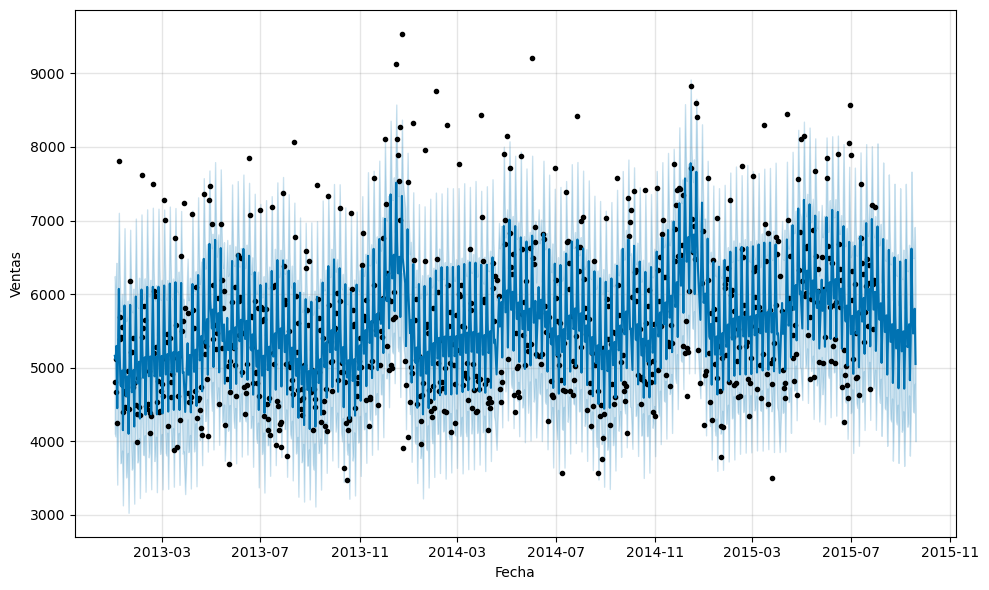

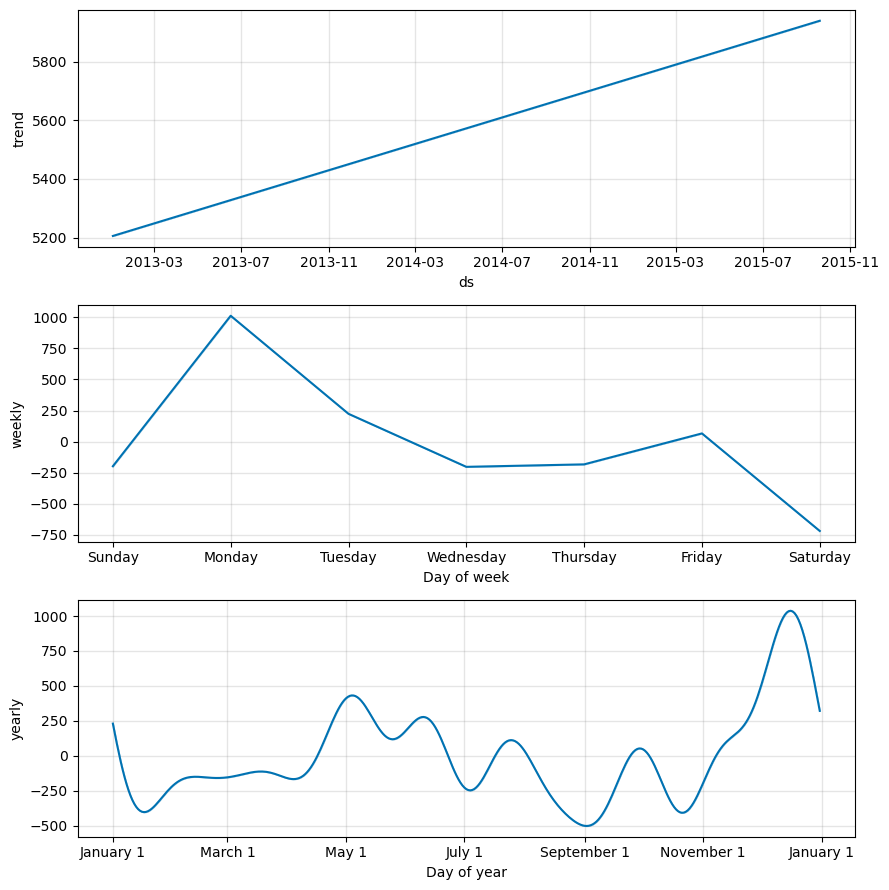

In [49]:
sales_predictions(10, df_all, 50)

In [50]:
def sales_predictions(Store_ID, df_sales, holidays , periods):
    df_sales = df_sales[df_sales['Store'] == Store_ID]
    df_sales = df_sales[['Date', 'Sales']].rename(columns = {'Date': 'ds', 'Sales': 'y'})
    df_sales = df_sales.sort_values('ds')

    model    = Prophet(holidays = holidays)
    model.fit(df_sales)
    future   = model.make_future_dataframe(periods = periods)
    forecast = model.predict(future)
    figure   = model.plot(forecast, xlabel = "Fecha", ylabel = "Ventas")
    figure2  = model.plot_components(forecast)

In [51]:
school_holiday = df_all[df_all['SchoolHoliday'] == 1].loc[:,'Date'].values
school_holiday

array(['2015-07-31', '2015-07-30', '2015-07-29', ..., '2013-01-04',
       '2013-01-03', '2013-01-02'], dtype=object)

In [52]:
school_holiday = np.unique(school_holiday)
school_holiday.shape

(477,)

In [53]:
state_holidays = df_all[(df_all['StateHoliday']=='a') | (df_all['StateHoliday'] == 'b') | (df_all['StateHoliday'] == 'c')].loc[:, 'Date']

state_holidays = np.unique(state_holidays)
state_holidays.shape

(35,)

In [54]:
school_holidays = pd.DataFrame({'ds': pd.to_datetime(school_holiday), 'holiday':'school_holiday'})
state_holidays = pd.DataFrame({'ds': pd.to_datetime(state_holidays), 'holiday':'state_holiday'})

In [55]:
school_state_holidays = pd.concat((state_holidays, school_holidays), axis = 0)

14:43:17 - cmdstanpy - INFO - Chain [1] start processing
14:43:17 - cmdstanpy - INFO - Chain [1] done processing


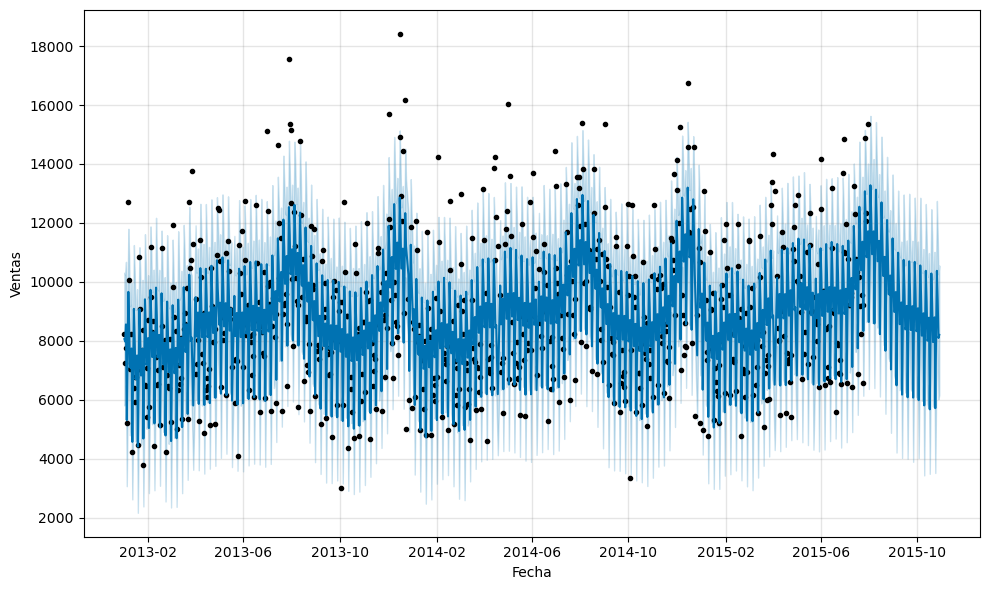

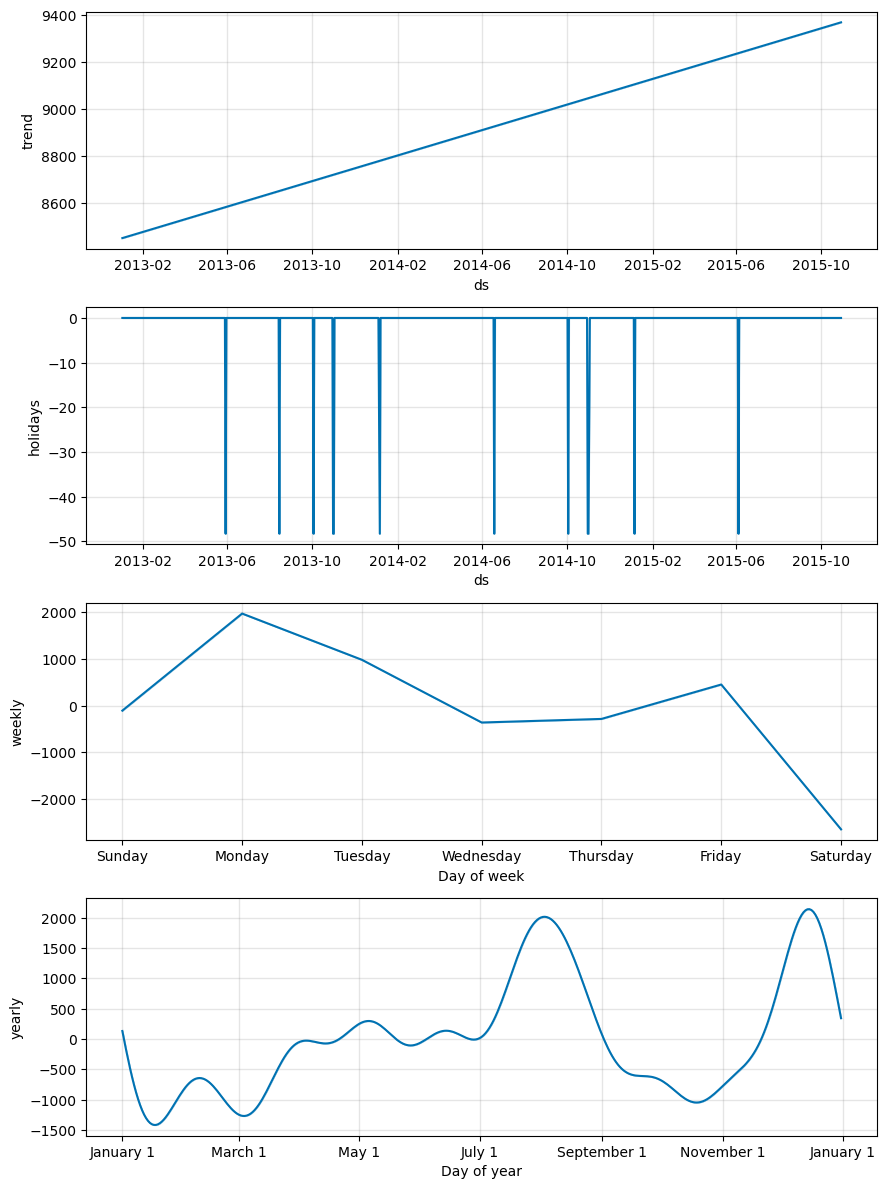

In [56]:
sales_predictions(7, df_all,state_holidays, 90)